<a href="https://colab.research.google.com/github/yarayear2056-cmd/Week4_pro/blob/main/bird_species.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kagglehub

In [ ]:
import kagglehub
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from torchvision.models import ResNet18_Weights
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import copy

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
path = kagglehub.dataset_download("pavangawande/indian-bird-species-dataset-traintest-split")
print("Path to dataset files:", path)

100%|██████████| 15.3G/15.3G [02:22<00:00, 115MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/pavangawande/indian-bird-species-dataset-traintest-split/versions/1


In [ ]:
print(os.listdir(path))


['Birds25_Split']


In [ ]:
base_path = os.path.join(path, os.listdir(path)[0])
print(os.listdir(base_path))

['test', 'train']


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [ ]:
train_path = os.path.join(base_path,"train")
test_path = os.path.join(base_path,"test")

In [ ]:
#dataset
train_data = datasets.ImageFolder(train_path, transform=transform)
test_data = datasets.ImageFolder(test_path, transform=transform)
#data loader
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16)

In [ ]:
#for small data
small_train_data = Subset(train_data, range(1000))
small_test_data = Subset(test_data, range(500))

small_train_loader = DataLoader(small_train_data, batch_size=32, shuffle=True)
small_test_loader = DataLoader(small_test_data, batch_size=32)

In [ ]:
#load model
num_classes = len(train_data.classes)

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)

In [ ]:
def get_model(freeze_backbone=True):
    model = models.resnet18(weights=ResNet18_Weights.DEFAULT)

    if freeze_backbone:
        for p in model.parameters():
            p.requires_grad = False

    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.to(device)
    return model


In [ ]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    loss_sum, correct, total = 0,0,0

    for x,y in loader:
        x,y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out,y)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        pred = out.argmax(1)
        correct += (pred==y).sum().item()
        total += y.size(0)

    return loss_sum/len(loader), correct/total


def eval_one_epoch(model, loader, criterion):
    model.eval()
    loss_sum, correct, total = 0,0,0

    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out,y)

            loss_sum += loss.item()
            pred = out.argmax(1)
            correct += (pred==y).sum().item()
            total += y.size(0)

    return loss_sum/len(loader), correct/total

In [ ]:
def run_research_experiment(name, model, train_loader, val_loader, epochs=2):
    print(f"\n===== Experiment: {name} =====")

    params = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = optim.SGD(params, lr=0.001, momentum=0.9)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    criterion = nn.CrossEntropyLoss()


    since = time.time()
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}

    for epoch in range(epochs):
        print(f"Epoch {epoch}/{epochs-1}")
        print("-"*10)

        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        val_loss, val_acc = eval_one_epoch(model, val_loader, criterion)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")
        print(f"val   Loss: {val_loss:.4f} Acc: {val_acc:.4f}\n")


        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f"Training complete in {int(time_elapsed//60)}m {int(time_elapsed%60)}s")
    print(f"Best val Acc: {best_acc:.6f}")

    model.load_state_dict(best_model_wts)

    return


In [ ]:
freeze_small = get_model(freeze_backbone=True)

run_research_experiment(
    "freeze + small data",
    freeze_small,
    small_train_loader,
    small_test_loader

)


===== Experiment: freeze + small data =====
Epoch 0/1
----------
train Loss: 0.3796 Acc: 0.9130
val   Loss: 7.6876 Acc: 0.5960

Epoch 1/1
----------
train Loss: 0.0000 Acc: 1.0000
val   Loss: 8.2931 Acc: 0.5960

Training complete in 0m 43s
Best val Acc: 0.596000


In [ ]:
freeze_large = get_model(freeze_backbone=True)
run_research_experiment(
    "freeze + large data",
    freeze_large,
    train_loader,
    test_loader
)


===== Experiment: freeze + large data =====
Epoch 0/1
----------
train Loss: 1.9064 Acc: 0.4573
val   Loss: 1.4604 Acc: 0.5740

Epoch 1/1
----------
train Loss: 1.5083 Acc: 0.5555
val   Loss: 1.3609 Acc: 0.6010

Training complete in 20m 49s
Best val Acc: 0.601000


In [ ]:
unfreeze_small = get_model(freeze_backbone=False)
run_research_experiment(
    "unfreeze + small data",
    unfreeze_small,
    small_train_loader,
    small_test_loader
)


===== Experiment: unfreeze + small data =====
Epoch 0/1
----------
train Loss: 0.3754 Acc: 0.9130
val   Loss: 7.5649 Acc: 0.5960

Epoch 1/1
----------
train Loss: 0.0000 Acc: 1.0000
val   Loss: 7.9629 Acc: 0.5960

Training complete in 0m 47s
Best val Acc: 0.596000


In [ ]:
unfreeze_large = get_model(freeze_backbone=False)
run_research_experiment(
    "unfreeze + large data",
    unfreeze_large,
    train_loader,
    test_loader
)


===== Experiment: unfreeze + large data =====
Epoch 0/1
----------
train Loss: 1.2602 Acc: 0.6339
val   Loss: 0.8205 Acc: 0.7475

Epoch 1/1
----------
train Loss: 0.7007 Acc: 0.7905
val   Loss: 0.7039 Acc: 0.7839

Training complete in 23m 38s
Best val Acc: 0.783948


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

def plot_confusion_matrix(model, loader, class_names):
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            outputs = model(x)
            preds = torch.argmax(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.numpy())

    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(12,10))
    sns.heatmap(cm, annot=False, cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


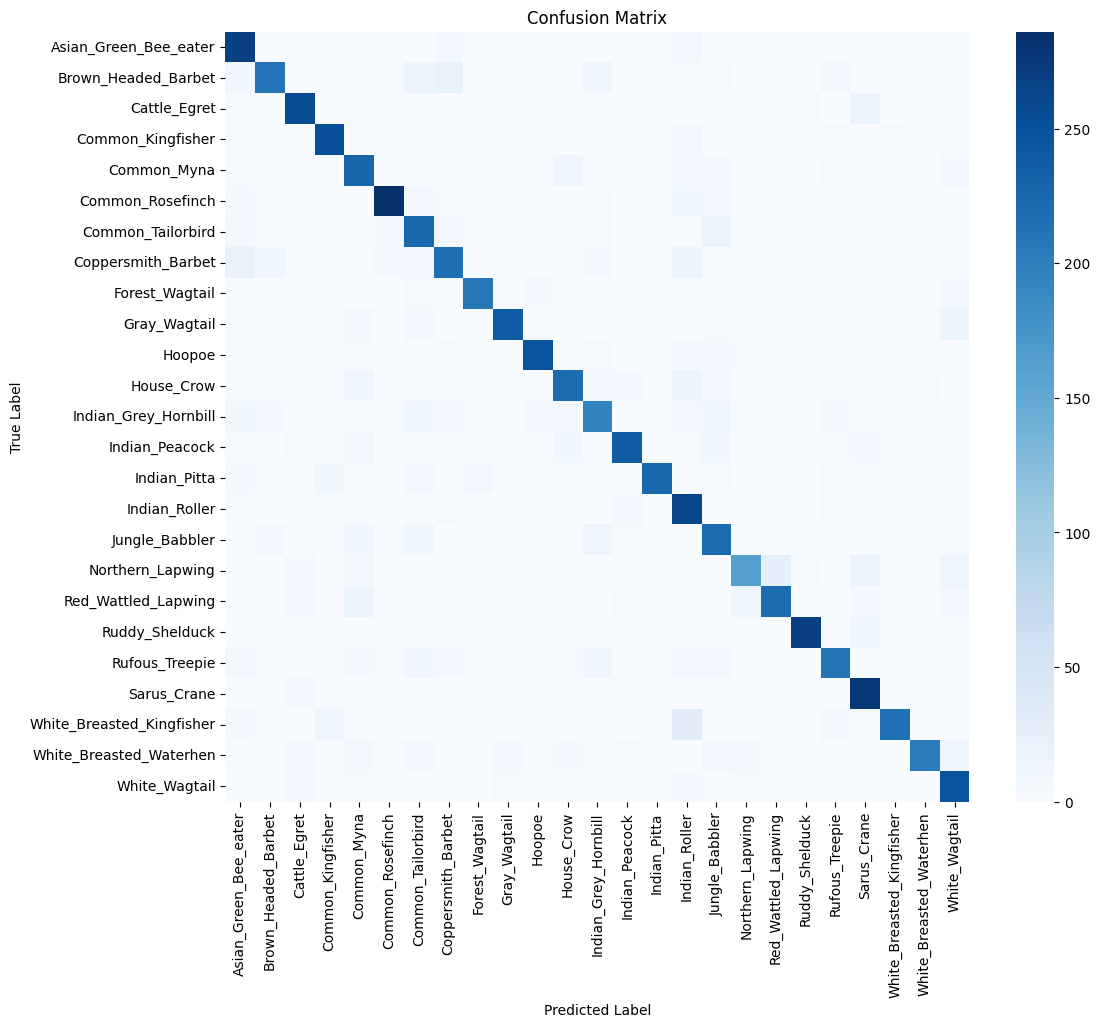

In [ ]:
plot_confusion_matrix(unfreeze_large, test_loader, train_data.classes)


In [ ]:
def show_birds_grid(loader, class_names, rows=2, cols=3):
    model_images, model_labels = next(iter(loader))

    plt.figure(figsize=(cols*3, rows*3))

    for i in range(rows * cols):
        img = model_images[i]

        # فك التطبيع (unnormalize)
        img = img.permute(1, 2, 0)
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        img = img.clamp(0, 1)

        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.title(class_names[model_labels[i]])
        plt.axis("off")

    plt.tight_layout()
    plt.show()


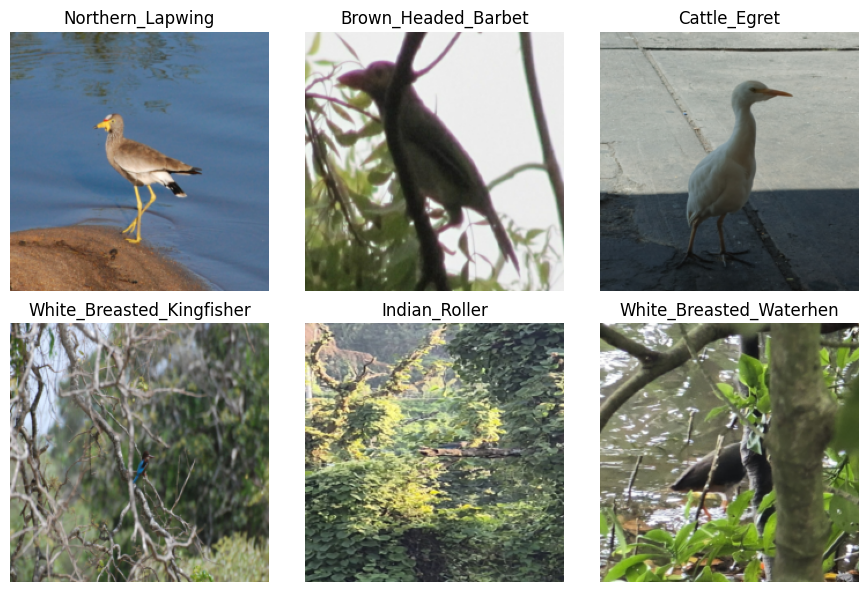

In [ ]:
show_birds_grid(train_loader, train_data.classes)
